# Notebook for finding cumulative annual sum of mean severe hail grid days for US subregions

### Import libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
import statistics
import matplotlib.patheffects as pe

## Import WRF subregional files (switch between regions)

In [2]:
hist = xr.open_dataset('/home/scratch/jgoodin/US_subregions/hist_midwest_daily_max.nc') #Open hist daily max .nc file saved to /home/scratch directory
mid4p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/mid4p5_midwest_daily_max.nc') #Open mid-FUTR 4.5 daily max .nc file saved to /home/scratch directory
mid8p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/mid8p5_midwest_daily_max.nc') #Open mid-FUTR 8.5 daily max .nc file saved to /home/scratch directory
end4p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/end4p5_midwest_daily_max.nc') #Open end-FUTR 4.5 daily max .nc file saved to /home/scratch directory
end8p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/end8p5_midwest_daily_max.nc') #Open end-FUTR 8.5 daily max .nc file saved to /home/scratch directory

In [3]:
hist #Print out dataset- make sure daily data are returned and lats/lons are correct

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 244, west_east: 293)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Pass hail day threshold

In [4]:
hist_sev = 1 * (hist >= 0.0254)
mid4p5_sev = 1 * (mid4p5 >= 0.0254)
mid8p5_sev = 1 * (mid8p5 >= 0.0254) #Convert each WRF grid cell meeting sev hail size threshold to value of 1 to sum hail days
end4p5_sev = 1 * (end4p5 >= 0.0254)
end8p5_sev = 1 * (end8p5 >= 0.0254)

In [5]:
hist_sev #Print out results- # of days should be the same

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 244, west_east: 293)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## For each climate epoch, groupby month and sum along 'Time' dim. Provides monthly count of total hail days in given region

In [117]:
hist_days = hist_sev.groupby('Time.dayofyear').sum()
#mid4p5_days = mid4p5_sev.sum()
#mid8p5_days = mid8p5_sev.sum() #Use xarray's groupby function to group data by month and sum hail days along each month
#end4p5_days = end4p5_sev.sum()
#end8p5_days = end8p5_sev.sum()

In [120]:
hist_days #Print out one climate epoch- should contain a 'month' dim

<xarray.Dataset>
Dimensions:     (dayofyear: 366, south_north: 244, west_east: 293)
Coordinates:
  * dayofyear   (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (dayofyear, south_north, west_east) int64 0 0 0 0 0 ... 0 0 0 0

## Find the mean number of hail days per month per region by taking mean across lats/lons of region (south_north, west_east coords)

### NOTE: this should return one value per month. Make sure 'month' dim is still there for each epoch

In [107]:
hist_mean_days = hist_days.mean(('south_north', 'west_east'))
mid4p5_mean_days = mid4p5_days.mean(('south_north', 'west_east'))
mid8p5_mean_days = mid8p5_days.mean(('south_north', 'west_east')) #Find mean monthly values across lats/lons of each region
end4p5_mean_days = end4p5_days.mean(('south_north', 'west_east'))
end8p5_mean_days = end8p5_days.mean(('south_north', 'west_east'))

In [108]:
hist_mean_days

<xarray.Dataset>
Dimensions:     (month: 12)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    HAIL_MAX2D  (month) float64 9.056 17.06 22.32 39.09 ... 33.32 23.44 10.59

## Find 25th and 75th percentiles for each climate epoch for each month to plot along with means

### Find 25th percentiles for each month

In [ ]:
hist_lower = hist_days.reduce(np.percentile, q = 25)
#mid4p5_lower = 
#mid8p5_lower = 
#end4p5_lower = 
#end8p5_lower = 

In [ ]:
hist_lower

### Find 75th percentiles for each month

In [ ]:
hist_upper = 
mid4p5_upper = 
mid8p5_upper =
end4p5_upper =
end8p5_upper =

## Plot monthly means, percentiles for each US region

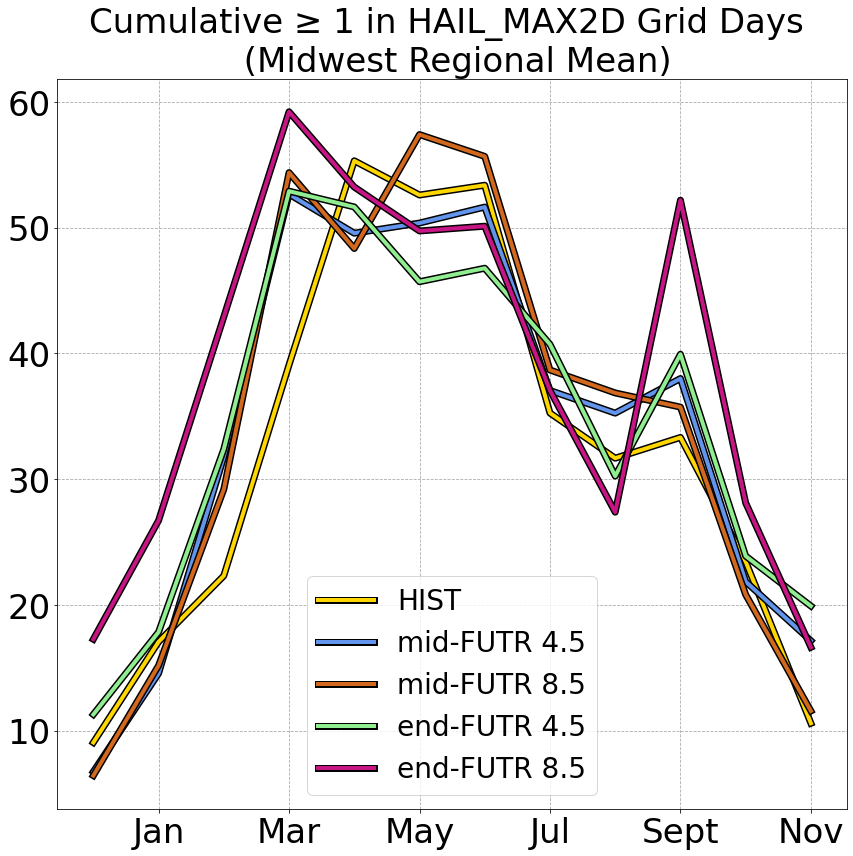

In [109]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.plot(hist_mean_days.HAIL_MAX2D, color = 'gold', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "HIST")
plt.plot(mid4p5_mean_days.HAIL_MAX2D, color = 'cornflowerblue', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "mid-FUTR 4.5")
plt.plot(mid8p5_mean_days.HAIL_MAX2D, color = 'chocolate', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "mid-FUTR 8.5")
plt.plot(end4p5_mean_days.HAIL_MAX2D, color = 'lightgreen', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "end-FUTR 4.5")
plt.plot(end8p5_mean_days.HAIL_MAX2D, color = 'mediumvioletred', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "end-FUTR 8.5")

plt.grid(color = 'darkgray', linestyle = '--')
ax.set_title('Cumulative ≥ 1 in HAIL_MAX2D Grid Days \n (Midwest Regional Mean)', fontsize = 34)
#ax.set_yticks([(10**0), (10**1), (10**2), (10**3), (10**4), (10**5), (10**6), (10**7), (10**8)])
#ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5])
plt.xticks([1, 3, 5, 7, 9, 11], ["Jan", "Mar", "May", "Jul", "Sept", "Nov"], fontsize = 34)
plt.yticks(fontsize = 34)
plt.legend(fontsize=28, loc='lower center')
plt.tight_layout()
#plt.savefig('/home/scratch/jgoodin/grid_count_figures/annual_hail_dist_midwest.png')
plt.show()